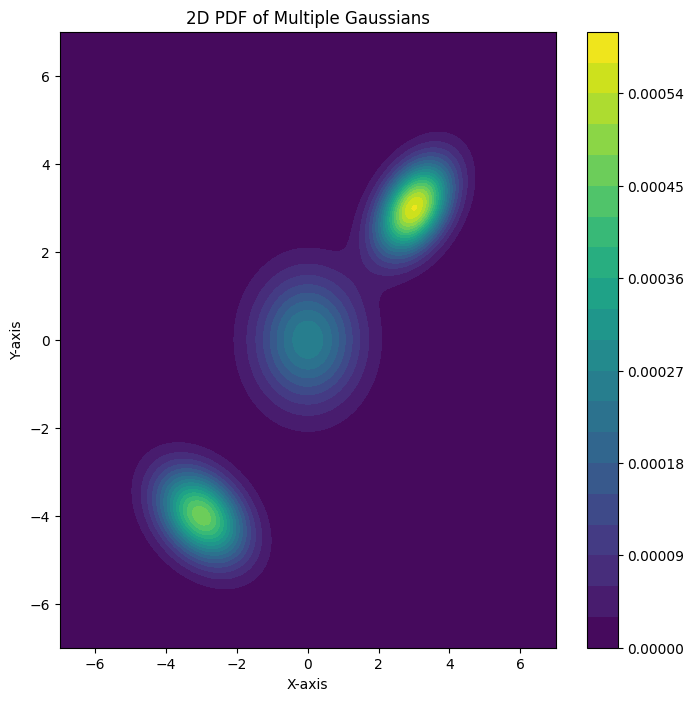

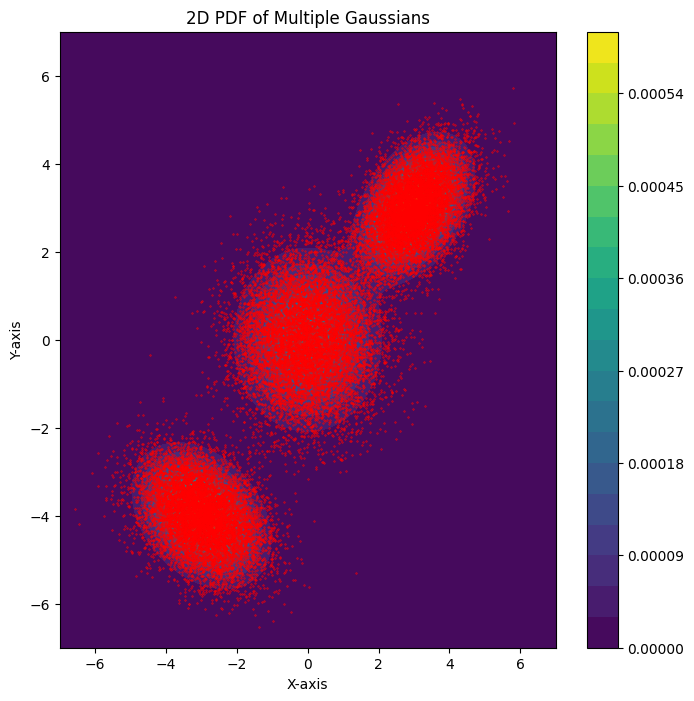

In [172]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Define parameters for multiple Gaussians
means = [(0, 0), 
         (3, 3), 
         (-3, -4)]  # Centers of the Gaussians
covariances = [ [[1, 0], 
                 [0, 1]], 
               [[0.5, 0.2], 
                [0.2, 0.5]], 
               [[0.7, -0.2], 
                [-0.2, 0.5]] ]  # Covariance matrices
sizes = [10000,
         10000,
         10000]

# Generate grid for plotting
x = np.linspace(-7, 7, 200)
y = np.linspace(-7, 7, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Create the combined Gaussian distribution
Z = np.zeros(X.shape)
data_samples = []
for mean, cov, size in zip(means, covariances, sizes):
    rv = np.random.multivariate_normal(mean, cov, size=(size,))
    data_samples.append(rv)
    Z += np.exp(-0.5 * (np.sum(np.dot(pos - mean, np.linalg.inv(cov)) * (pos - mean), axis=2))) * np.linalg.det(cov)**(-1/2) * size
data_samples = np.vstack(data_samples)

# Normalize the combined distribution
Z /= np.sum(Z)

# Plot the 2D PDF
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Plot the 2D PDF
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.scatter(data_samples[:,0], data_samples[:,1], c='r', s=1, marker='x', alpha=0.5)
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()



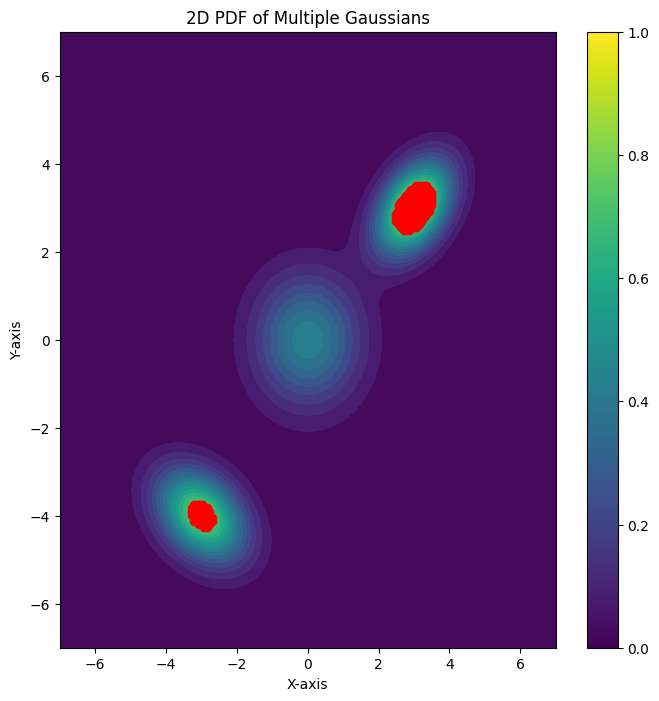

In [173]:
# Flatten the Z array and sort it in descending order
Z_flat = Z.flatten()
sorted_indices = np.argsort(Z_flat)[::-1]
sorted_Z = Z_flat[sorted_indices]

# Calculate the cumulative sum and find the threshold index
cumulative_sum = np.cumsum(sorted_Z)
threshold_index = np.where(cumulative_sum >= 0.1)[0][0]

# Get the x, y coordinates for the corresponding indices
top_indices = sorted_indices[:threshold_index+1]
top_x = X.flatten()[top_indices]
top_y = Y.flatten()[top_indices]

plt.figure(figsize=(8, 8))
# Plot the 2D PDF
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.scatter(top_x, top_y, c='red')
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


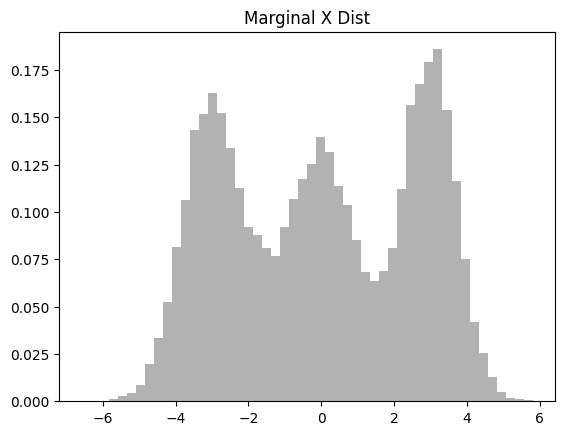

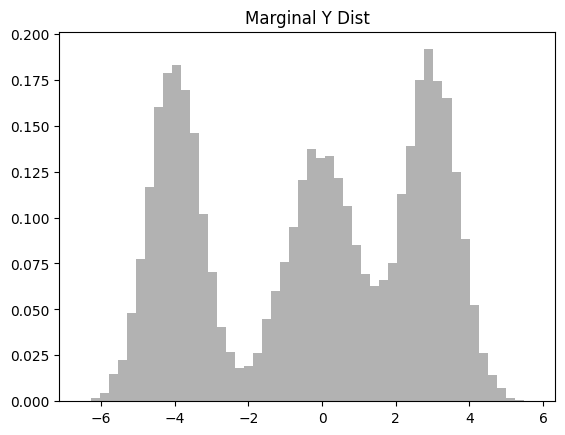

In [221]:
# Get X Centers
plt.figure()
plt.title("Marginal X Dist")
X_bin_count = 50
X_hist = plt.hist(data_samples[:,0], bins=X_bin_count, density=True, alpha=0.6, color='gray', label='Data')
X_digital_labels = np.fmin(np.digitize(data_samples[:,0], X_hist[1]), X_bin_count)

# Get Y Centers
plt.figure()
plt.title("Marginal Y Dist")
Y_bin_count = 50
Y_hist = plt.hist(data_samples[:,1], bins=Y_bin_count, density=True, alpha=0.6, color='gray', label='Data')
Y_digital_labels = np.fmin(np.digitize(data_samples[:,1], Y_hist[1]), Y_bin_count)

digital_labels = ((X_digital_labels-1) + (Y_digital_labels-1) * Y_bin_count)

In [175]:
def get_cuda_summary(memory=False):
    import torch

    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')

import torch
get_cuda_summary()
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_device(0) if torch.cuda.is_available() else None

CUDA device =  NVIDIA TITAN RTX
Available number of devices =  1
Device numbers              =  [0]
Current device              =  0


In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnconditionalClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=50*50):
        super(UnconditionalClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.no_of_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [223]:
# CROSS ENTROPY LOSS
train_y = torch.from_numpy((digital_labels).reshape(-1)).to(device)
train_x = torch.zeros_like(train_y).reshape(-1,1).float().to(device)

model = UnconditionalClassifier().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

In [224]:
losses = []
for step in range(2000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x)
    loss = criterion(logits, train_y)
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 100 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=7.835
epoch 100 loss=6.258
epoch 200 loss=6.247
epoch 300 loss=6.245
epoch 400 loss=6.244
epoch 500 loss=6.243
epoch 600 loss=6.243
epoch 700 loss=6.243
epoch 800 loss=6.243
epoch 900 loss=6.243
epoch 1000 loss=6.243
epoch 1100 loss=6.243
epoch 1200 loss=6.243
epoch 1300 loss=6.243
epoch 1400 loss=6.243
epoch 1500 loss=6.243
epoch 1600 loss=6.243
epoch 1700 loss=6.243
epoch 1800 loss=6.243
epoch 1900 loss=6.243
epoch 2000 loss=6.243


In [225]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
X_bin_centers = moving_average(X_hist[1])
Y_bin_centers = moving_average(Y_hist[1])

xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
cluster_coordinates = np.array(list(zip(xx.flatten(), yy.flatten()))).shape

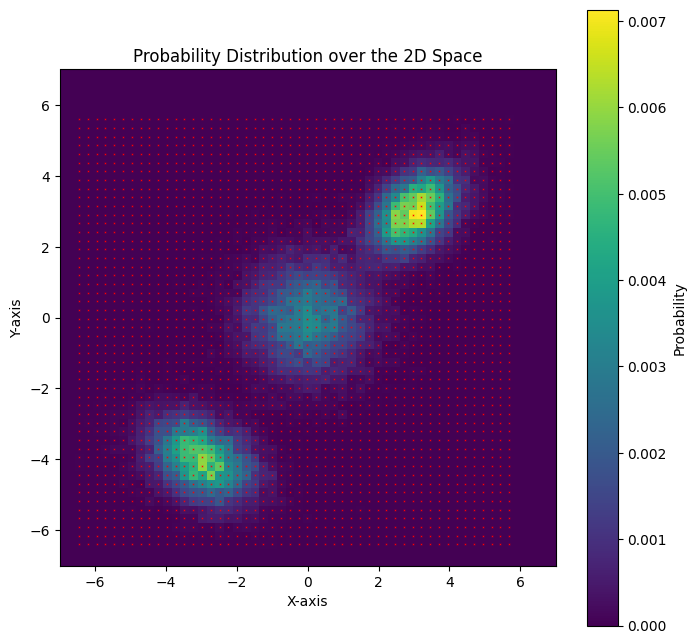

In [257]:
# Ensure the model is in evaluation mode
model.eval()

# Feed the input tensor with value 0
input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

# Generate model predictions
with torch.no_grad():  # Disable gradient calculation for inference
    output_logits = model(input_tensor)

# Apply softmax to get the probability distribution over the output classes
output_probs = torch.softmax(output_logits, dim=1).cpu().numpy().reshape(50, 50)

# Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

# Plot the probability distribution over the 2D grid using the bin edges
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

# Get the colormap and set the color for under 0 values
cmap = plt.get_cmap('viridis')

# Set vmin to 0 to make sure the zero probability regions are colored
im = ax.imshow(output_probs, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), 
               origin='lower', cmap=cmap, vmin=0, vmax=output_probs.max())

# Set the facecolor of the axes to the color corresponding to the lowest value in the colormap
ax.set_facecolor(cmap(0))  # This sets the background to the same color as the lowest probability

# Set the xlim and ylim with no extra background
plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Add the colorbar and labels
plt.colorbar(im, ax=ax, label='Probability')
plt.title('Probability Distribution over the 2D Space')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display proto centers
xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
plt.scatter(xx.flatten(), yy.flatten(), marker='x', c='red', s=0.1)
plt.show()


In [16]:
######### PROTOTYPE 1 ####################33

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnconditionalProtoClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=50*50):
        super(UnconditionalProtoClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.no_of_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

(2500, 2)